## Time Series

## Final Project Submission

Please fill out:
* __Student name:__ Kristine Petrosyan
* __Student pace:__ part time
* __Project review date/time:__ TBD
* __Instructor name:__ Victor


> Below in the notebook will see time series to predict number of cancellations in the future.

In [64]:
import datetime
start = datetime.datetime.now()

# Import Libraries 

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import itertools

import warnings
warnings.filterwarnings("ignore")

# Functions

> __While writing this function will try to eliminate the trend__

There are multiple ways to eliminate trends:

1.Taking the log transformation - The advantage of taking a log transformation is that higher values are penalized more than lower values. Alternatives for the log transformation are the square root, cube root transformations, etc.

2.Subtracting the rolling mean -  You can calculate the rolling mean and subtract it from the time series to make sure your time series is stationary. 

3.Differencing - One of the most common methods of dealing with both trend and seasonality is differencing. It takes the difference of an observation at a particular time instant with that at the previous instant.  This mostly works pretty well in improving stationarity. Differencing can be done in Pandas using the .diff() method with periods=1.

In [66]:
def eliminate_trends(df, text='Time Series Dataset'):
    ''' Eliminating Trends '''
    
    display(f"Eliminating Trends for {text} - Original Data")
    
    # Differencing Original data - periods - 52
    #    One of the most common methods of dealing with both trend and seasonality is differencing.

    data = df
    orig_data_diff = data.diff(periods=52)
    orig_data_diff.dropna(inplace=True)
    test_stationarity(orig_data_diff, text, '- Original Data .diff(period=52)')

In [67]:
# Assess stationarity of time series
def test_stationarity(df, text='Time Series Dataset', title='- Original Dataset'):
    ''' TEST 1: Perform Rolling Statistics on Mean and Standard Deviation
        TEST 2: Perform Statistical Test - Augmented Dickey-Fuller (ADF) Test
    '''
    
    # Calculate rolling mean and standard deviation using a 365 month window
    rolmean = df.rolling(window=52, center=False).mean() 
    rolstd = df.rolling(window=52, center=False).std()   
    
    # Plot rolling mean and standard deviation against the original time series data
    fig = plt.figure(figsize=(6,4))
    original = plt.plot(df, label='Original', color='blue')
    mean = plt.plot(rolmean, label = 'Rolling Mean', color="red")
    std = plt.plot(rolstd, label = 'Rolling Standard Deviation', color="black")
    plt.title(f"Stationarity Check for {text} {title}")
    plt.legend()
    plt.show(block=False)
    
    # Conduct a Dickey-Fuller test on time series to provide a statistical measure of stationarity
    dftest = adfuller(df['is_canceled']) 
    
    # Create an easy-to-read series with key Dickey-Fuller parameters
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print('Results of Dickey-Fuller Test')
    print(dfoutput)

# Load the Data

In [68]:
data = pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [69]:
data.shape

(119390, 32)

# EDA

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

#### Check for Missing Values in dataset

In [71]:
data.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

# Scrub the Data

In [72]:
df = data.copy()

- To ensure dates are understood correctly we change the dates in our dataset from "non-null object" to "non-null datetime". This can be done using the to_datetime() function from Pandas. 

In [73]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], infer_datetime_format=True)

In [74]:
# Add column to capture day of week - 0 (Monday) to 6 (Sunday)
df['Day of Week'] = df['reservation_status_date'].apply(lambda time: time.dayofweek)

In [75]:
# Drop column(s) due to alot of missing entries (or pre-preprocessing column(s))
df = df.drop(['company'], axis=1) 

In [76]:
# Drop rows with missing values
df = df.dropna().reset_index(drop=True)

In [77]:
df.isnull().any().any()

False

In [78]:
# Add column for lead_time_catg
leadTime_bin = np.array([0,7,14,30,60,90,180,270,365,800]) 
df['leadTime_catg'] = pd.cut(df['lead_time'], leadTime_bin)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Day of Week,leadTime_catg
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,3,"(7, 14]"
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,4,"(7, 14]"
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,4,"(7, 14]"
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,303.0,0,Transient,103.0,0,1,Check-Out,2015-07-03,4,"(7, 14]"
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,240.0,0,Transient,82.0,0,1,Canceled,2015-05-06,2,"(60, 90]"


In [79]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Day of Week,leadTime_catg
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,3,"(7, 14]"
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,4,"(7, 14]"
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,4,"(7, 14]"
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,303.0,0,Transient,103.0,0,1,Check-Out,2015-07-03,4,"(7, 14]"
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,240.0,0,Transient,82.0,0,1,Canceled,2015-05-06,2,"(60, 90]"


In [80]:
df.shape

(102894, 33)

# Preview and Identify dataset for analysis

In [81]:
# Aggregate data
df_ts_daily = df.groupby(by='reservation_status_date')['is_canceled'].agg(sum).reset_index()
df_ts_daily.head()

,reservation_status_date,is_canceled
0,2014-10-17,180
1,2014-11-18,1
2,2015-01-01,763
3,2015-01-02,7
4,2015-01-20,2


- Aggregate data in dataset to daily level. 

#### Set date as index for Time Series

In [82]:
# Set Date as index 
df_ts_daily.set_index(['reservation_status_date'], inplace=True)

In [83]:
df_ts_daily.head(5)

,is_canceled
reservation_status_date,
2014-10-17,180
2014-11-18,1
2015-01-01,763
2015-01-02,7
2015-01-20,2


- Reservation Status Date Range: 

    start: __2014-10-17__ (YY-MM-DD) | 
    end  : __2017-09-14__ (YY-MM-DD)

In [84]:
# Which dates have NO cancellations?
df_ts_daily[df_ts_daily['is_canceled'] == 0]

,is_canceled
reservation_status_date,
2015-07-05,0
2015-07-19,0
2015-07-26,0
2015-08-02,0
2015-08-16,0
2015-08-30,0
2015-09-27,0
2015-10-11,0
2015-10-25,0


In [85]:
df_ts_daily.shape

(923, 1)

# Time Series Analysis

## Daily | Analysis

In [86]:
#Plotting Styling Properties
plt.style.use('seaborn')

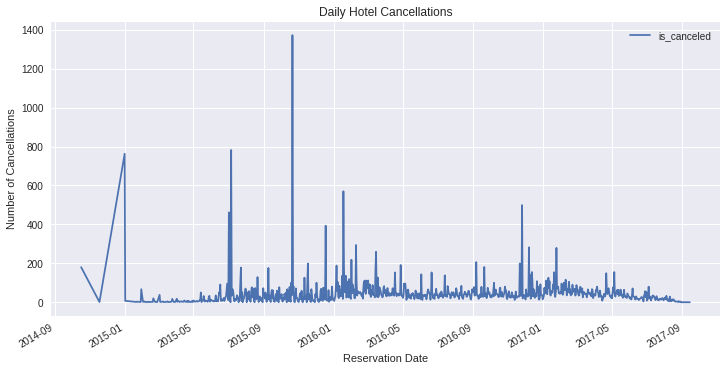

In [87]:
# Plot Hotel Cancellations by Reservation Date (Daily)
df_ts_daily.plot(figsize=(12,6))
plt.title("Daily Hotel Cancellations")
plt.xlabel("Reservation Date")
plt.ylabel("Number of Cancellations")
plt.show()

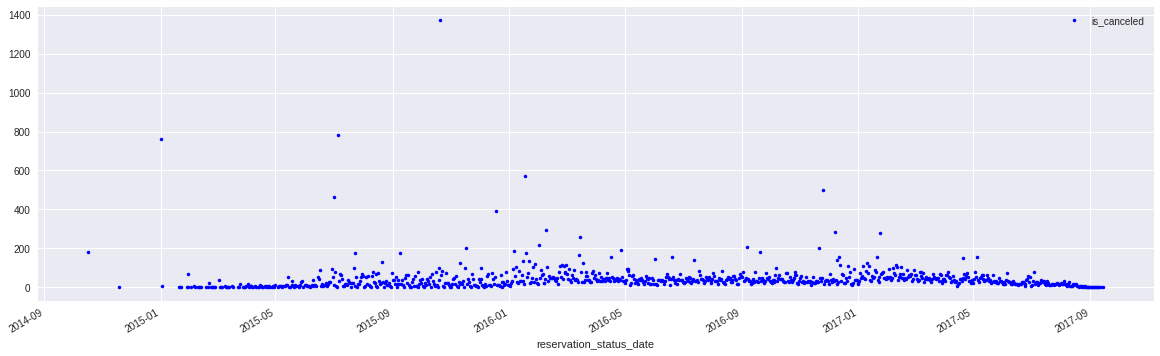

In [88]:
# Draw a dot plot of daily cancellations
df_ts_daily.plot(figsize = (20,6), style = '.b');

- Dot plots can prove to be very helpful in identifying outliers and very small patterns which may not be so obvious otherwise.

In [89]:
# Which dates have cancellations greater than 200 in a day?
df_ts_daily[df_ts_daily['is_canceled'] > 200]

,is_canceled
reservation_status_date,
2015-01-01,763
2015-07-02,462
2015-07-06,782
2015-10-21,1372
2015-12-18,393
2016-01-18,570
2016-02-01,218
2016-02-09,294
2016-03-15,259


## Weekly | Analysis - Resample Data

> Using daily data for time series modeling contains too much variation as shown in graph above.  So, we will resample the day by week and use this to predict hotel cancellations.

In [90]:
# Resample the day by week
df_ts = df_ts_daily.resample('W').mean()

In [91]:
# Use the fillna() function to ensure that we have no missing values in our time series. 

# The term bfill means that we use the value before filling in missing values
df_ts = df_ts.fillna(df_ts.bfill())

In [92]:
# Verify index is a DatetimeIndex:
df_ts.info()
# <class 'pandas.core.frame.DataFrame'>
# DatetimeIndex: 153 entries, 2014-10-19 to 2017-09-17
# Freq: W-SUN

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2014-10-19 to 2017-09-17
Freq: W-SUN
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_canceled  153 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


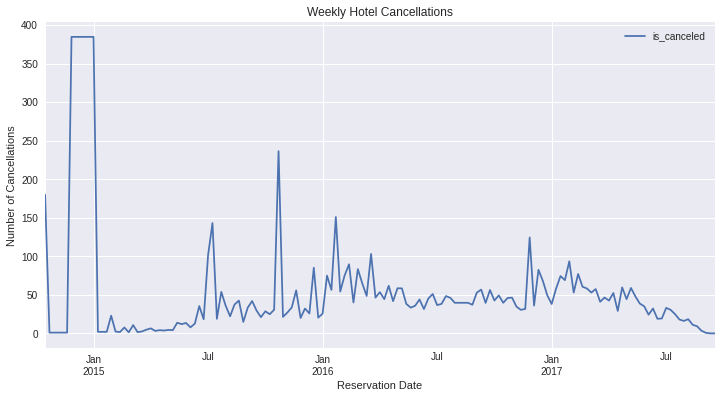

In [93]:
# Plot Hotel Cancellations by Reservation Date (weekly)
df_ts.plot(figsize=(12,6))
plt.title("Weekly Hotel Cancellations")
plt.xlabel("Reservation Date")
plt.ylabel("Number of Cancellations")
plt.show()

In [94]:
df_ts.tail()

,is_canceled
reservation_status_date,
2017-08-20,9.285714
2017-08-27,3.428571
2017-09-03,0.714286
2017-09-10,0.000000
2017-09-17,0.000000


In [95]:
df_ts.describe()

,is_canceled
count,153.000000
mean,53.277933
std,75.151591
min,0.000000
25%,18.857143
50%,38.142857
75%,54.285714
max,385.000000


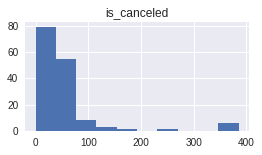

In [96]:
# Plot a histogram plot for  dataset
df_ts.hist(figsize = (4,2));

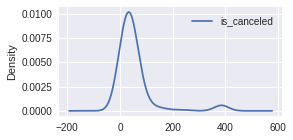

In [97]:
# Plot a density plot for  dataset
df_ts.plot(kind='kde', figsize = (4,2));

- The plot shows a distribution that is NOT Gaussian/Normal, instead, it is right-skewed.
- Histograms and density plots can be useful for getting a sense of the time-independent distribution of a time series.

## Monthly | Analysis - Resample Data

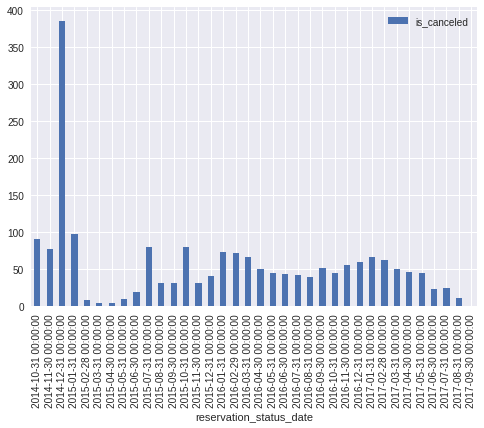

In [98]:
df_ts.resample('M').mean().plot.bar();

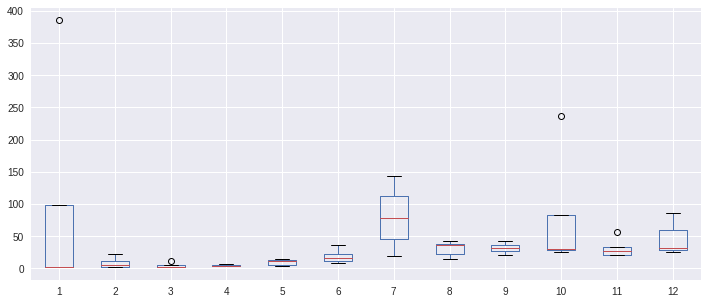

In [99]:
# Extract monthy values for 2015
ts_month = df_ts['2015-01-01':'2015-12-26']
#print(ts_month[:10])
# Group observations by month
groups_monthly = ts_month.groupby(pd.Grouper(freq ='M'))
#print(list(groups_monthly))
# Add each month to DataFrame as a column
months_2015 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_2015)

# Set the column names for each month i.e. 1,2,3, .., 12
months_df.columns = range(1,13)

# Plot the box and whiskers plot for each month 
months_df.boxplot(figsize = (12,5))
plt.show()

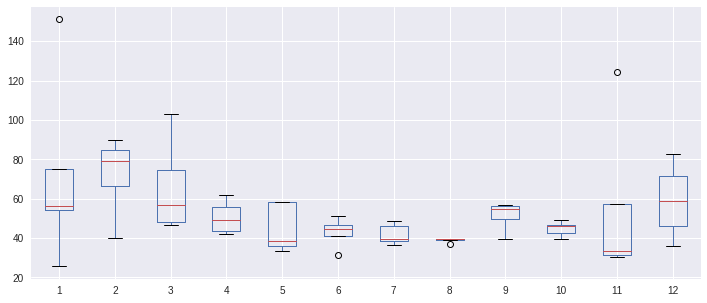

In [100]:
# Extract monthy values for 2016
ts_month = df_ts['2016-01-01':'2016-12-26']
#print(ts_month[:10])
# Group observations by month
groups_monthly = ts_month.groupby(pd.Grouper(freq ='M'))
#print(list(groups_monthly))
# Add each month to DataFrame as a column
months_2016 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_2016)

# Set the column names for each month i.e. 1,2,3, .., 12
months_df.columns = range(1,13)

# Plot the box and whiskers plot for each month 
months_df.boxplot(figsize = (12,5))
plt.show()

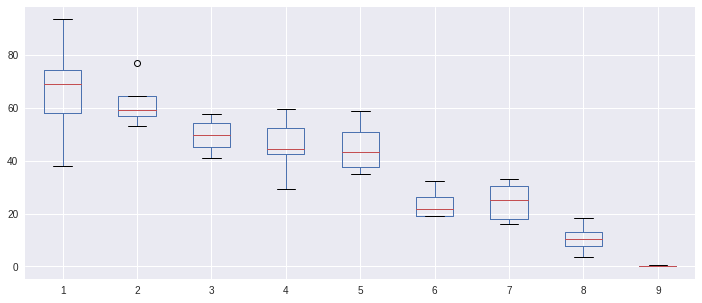

In [101]:
# Extract monthy values for 2017
ts_month = df_ts['2017-01-01':'2017-09-18']
#print(ts_month[:10])
# Group observations by month
groups_monthly = ts_month.groupby(pd.Grouper(freq ='M'))
#print(list(groups_monthly))
# Add each month to DataFrame as a column
months_2017 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_2017)

# Set the column names for each month i.e. 1,2,3, .., 12
months_df.columns = range(1,10)

# Plot the box and whiskers plot for each month 
months_df.boxplot(figsize = (12,5))
plt.show()

- We see 12 box and whisker plots, showing the significant change in the distribution of cancellations yearly.
- Box and whisker plots per year (or other seasonality period - day, week, month, etc) can be a great way to easily see trends in the distribution of time series data over time.

__Conclusion:__ I was hoping to see a consistent pattern that would identify the peak/low month(s) occurring yearly.  But, I did not see such a pattern in the yearly box plots.  For the year 2017 the number of cancellations appear to declining steady each month.

## Check Stationarity Assumptions

- A time series is said to be stationary if its statistical properties such as mean, variance, etc. remain constant over time.

- Why is it important? Because most time series models work on the assumption that the time series are stationary. For general time series datasets, if it shows a particular behavior over time, there is a very high probability that it will follow a similar behavior in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

#### Visually check for variance and mean assumptions

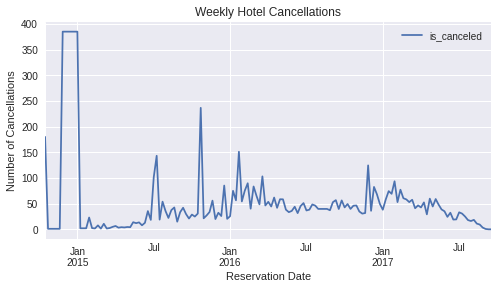

In [102]:
# Plot Hotel Cancellations by Reservation Date (weekly)
df_ts.plot(figsize=(8,4))
plt.title("Weekly Hotel Cancellations")
plt.xlabel("Reservation Date")
plt.ylabel("Number of Cancellations")
plt.show()

__No trend/Non-linear__ 

- Let's consider the weekly cancellations from January 2015 through July 2017. You'll notice that the trend goes up and down, but there is no clear direction, and over time, the index oscillates around 50. 

- Can not really determine in this visualization if there is any seasonality trends.

#### Calculate rolling mean and standard deviation

In [103]:
# Calculate rolling mean and standard deviation using a 365 month window
rolmean = df_ts.rolling(window=52, center=False).mean() 
rolstd = df_ts.rolling(window=52, center=False).std()   
print(rolmean, rolstd)

                         is_canceled
reservation_status_date             
2014-10-19                       NaN
2014-10-26                       NaN
2014-11-02                       NaN
2014-11-09                       NaN
2014-11-16                       NaN
...                              ...
2017-08-20                 45.593407
2017-08-27                 44.945055
2017-09-03                 43.942308
2017-09-10                 42.848901
2017-09-17                 42.087912

[153 rows x 1 columns]                          is_canceled
reservation_status_date             
2014-10-19                       NaN
2014-10-26                       NaN
2014-11-02                       NaN
2014-11-09                       NaN
2014-11-16                       NaN
...                              ...
2017-08-20                 21.396790
2017-08-27                 22.155227
2017-09-03                 22.955640
2017-09-10                 23.671360
2017-09-17                 24.403539

[153 rows x 1

## Conduct ADF Test

#### Augmented Dickey Fuller Test (ADF)  used  to check for stationarity assumption

> Augmented Dickey-Fuller test. Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. ... Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary.

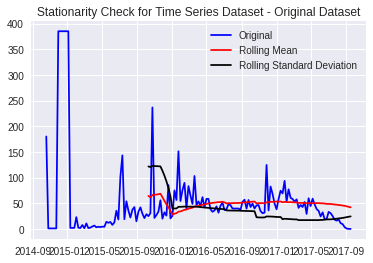

Results of Dickey-Fuller Test
Test Statistic                  -4.417816
p-value                          0.000276
#Lags Used                       2.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


In [104]:
test_stationarity(df=df_ts)

#### Visual Observations:
- By looking at the rolling mean to visually check if the mean changes over time, is appears that neither rolling mean or standard deviation is moving with the time.
- Both rolling mean and standard deviation seem to have constant values (neither is trending up or down), suggesting that the data is stationary.  However, we will verify with ADF test.

#### ADF Observations:
- The ADF test where p-value __0.000276__ < 0.05 indictes that the dataset is stationary.
- Test Statistic __-4.417816__ < -3.474715 - Critical Value (1%) indictes that the dataset is stationary with 99% confidence.

__Conclusions | Stationary Assumption__
> Test Statistic -4.417816 < -3.474715 - Critical Value (1%), shows that the time series is stationary with 99% confidence; p-value 0.000276 < 0.05 and the moving average is constant over time (you can draw a straight horizontal line through the original data) -- no specific trend, therefore, the null hypothesis of the ADF __can be rejected__.  These tests show that the weekly timeseries data is __stationary__.

## Decompose Time series Components

Time series decomposition is a mathematical procedure that transforms a time series into multiple different time series. The original time series is often split into three component series:

- Seasonal: Patterns that repeat within a fixed period. For example, a website might receive more visits during weekends; this would produce data with a seasonality of 7 days.

- Trend: The underlying trend of the metrics. A website increasing in popularity should show a general trend that goes up.

- Random: Also called "noise", "irregular", or "remainder", this is the residual of the original time series after the seasonal and trend series are removed.

To achieve successful decomposition, it is important to choose between the additive and multiplicative models, which requires analyzing the series. For example, does the magnitude of the seasonality increase when the time series increases?

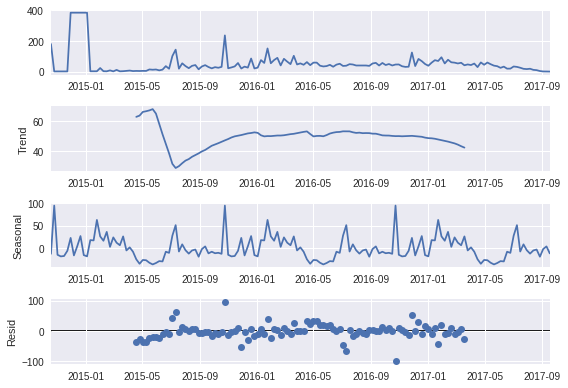

In [105]:
# Check for trend, seasonality and residual in dataset
decomposition = seasonal_decompose(df_ts, freq=52) # Defaut,additive model: Y[t]=T[t]+S[t]+e[t]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot();

> Does the magnitude of the seasonality increase when the time series increases? 
__No__, therefore, decomposition is __additive__.
- The additive model is Y[t] = T[t] + S[t] + e[t] = (default)

- Trend line is mostly horizontal or stationary.
- Seasonal line appears to be repeating with __yearly__ high peaks in Jan, Jul, Oct and low peaks in Apr, May.
- Residual - represents the anomalies (noise) in the dataset. Irregular fluctuations (noise) are abrupt changes that are random and unpredictable.

> Now that we have analyzed the data, we can clearly see we have a time series with a seasonal component for the following months: __Jan, Jul and Oct__. This will need to be controlled for by the model selected, such as, a Seasonal ARIMA model.

#### Residual Data Analysis 

The residuals, is the time series after the trend, and seasonal components are removed; let's check stationarity of residuals.  

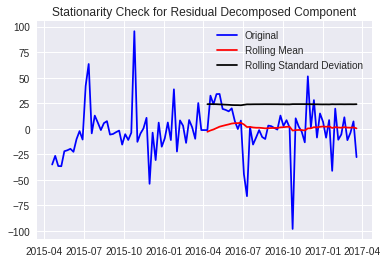

KeyError: 'is_canceled'

In [106]:
# Conduct stationary test on decomposed residual data
decomposedResidData = residual
decomposedResidData.dropna(inplace=True)  # Remove inf or nans from data
test_stationarity(decomposedResidData,text='Residual', title='Decomposed Component')

#### Observations:

>- The Dickey-Fuller test statistic is significant and very well below a (strict) 0.01 mark. So it seems reasonable to assume this time series is stationary.
- Residual data is stationary with p-value __0.000002__ < 0.05.  

 > __Conclusion__: We removed both trend and seasonality from a time-series using time series decomposition. Decomposition allows us to better model the time series for further analysis.

## Differencing Dataset

- Differencing is a very popular tool to remove seasonal trends from time series.

'Eliminating Trends for Time Series Dataset - Original Data'

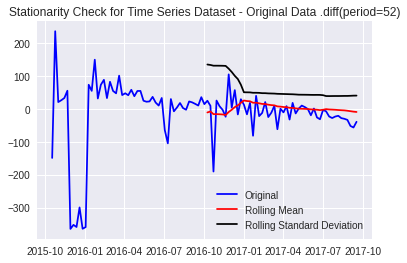

Results of Dickey-Fuller Test
Test Statistic                 -3.682288
p-value                         0.004369
#Lags Used                      1.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [107]:
# # Eliminate Trends to find dataset that mets stationary assumptions
eliminate_trends(df=df_ts)

> Here, we differenced the data by taking differences 52 weeks, to remove the yearly seasonality from the time series data.
- p-value: 0.004369 < 0.05, indicates stationary
- Test Statistic -3.682288 > Critical Value (1%)  -3.498198, indicates 99% confidence in the series being stationary.

# Time Series Modeling

## Plot ACF and PACF
> ACF and PACF will help to determine the p,d,q parameters for the models.

> We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

- __Autocorrelation Function (or ACF)__ is a very powerful tool for time series analysis. It helps us study how each time series observation is related to its recent (or not so recent) past. Processes with greater autocorrelation are more predictable than those without any form of autocorrelation.  The autocorrelation function is a function that represents autocorrelation of a time series as a function of the time lag.  The autocorrelation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.

- The autocorrelation function is one of the tools used to find patterns in the data. Specifically, the autocorrelation function tells you the correlation between points separated by various time lags. ... So, the ACF tells you how correlated points are with each other, based on how many time steps they are separated by.


- __Partial Autocorrelation Function (or PACF)__ gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags (unlike the autocorrelation function, which does not control for other lags). PACF can be thought of as a summary of the relationship between a time series element with observations at a lag, with the relationships of intervening observations removed.  The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

> The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.
It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

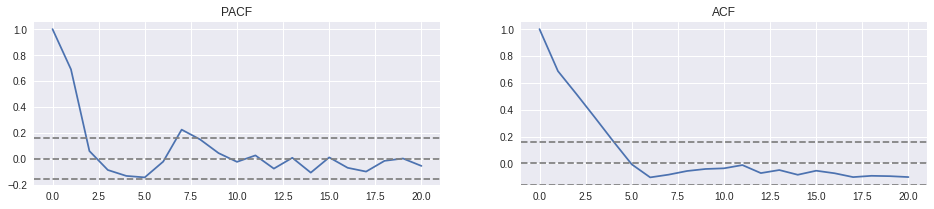

In [108]:
#  Plot ACF and PACF  - Graph #1
fig = plt.figure(figsize=(16,3))
lag_acf = acf(df_ts,  nlags = 20)
lag_pacf = pacf(df_ts, nlags = 20, method='ols')

# Plot PACF
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_ts)),linestyle='--', color='gray' )
plt.axhline(y=1.96/np.sqrt(len(df_ts)),linestyle='--', color='gray' )
plt.title('PACF')

# Plot ACF
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_ts)),linestyle='--', color='gray' )
plt.axhline(y=1.96/np.sqrt(len(df_ts)),linestyle='--', color='gray' )
plt.title('ACF')

plt.show()

- In the above correlation plot dotted lines represent the confidence band, with center dotted line represents mean and upper and lower dotted line represent boundries based on 95% confidence interval.
- __PACF__ In the above plot we can see that lags upto __2.5__ have good correlation before the plot drops to 'zero' for the first time. 
- __ACF__ In the above plot we can see that lags upto __4__ have good correlation before the plot first cuts the upper confidence interval.
- This will determine your p and q values for S/ARIMA modeling.

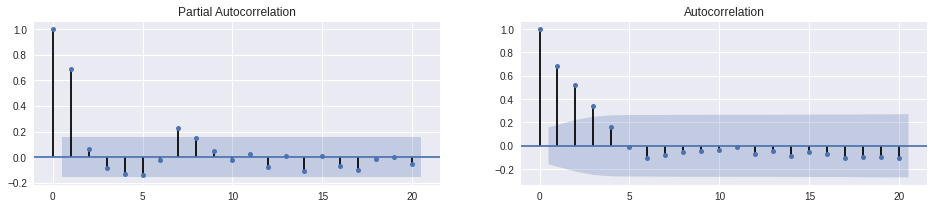

In [109]:
#  Plot ACF and PACF  - Graph #2
fig, axes = plt.subplots(ncols=2, nrows=1,figsize =(16,3))
plot_pacf(df_ts, ax= axes[0], lags=20, method='ols')  #p
plot_acf(df_ts,  ax= axes[1], lags=20)  # q


plt.subplots_adjust(hspace = 0.4 )
plt.show()

- Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- __ACF__ Indicates that 3 lags are significant at positive (0.7,0.5, and 0.3, respectively); for this time series, you can say that "Cancellations" are definitely autocorrelated for lags of 3 weeks, but for some later lags the result is not significant.
- __PACF__ Indicates that 1 lag and 7 lags is significant at positive (0.7 and 0.2,respectively); When controlling for 1 period, the PACF is only very high for one-period lags, and basically 0 for shorter lags, except for lag 7. 

> __ACF__ and __PACF__ will help to determine the p,q, P,Q parameters for the models.
ACF and PACF plots allow you to determine the AR and MA components of an S/ARIMA model. Both the Seasonal and the non-Seasonal AR and MA components can be determined from the ACF and PACF plots:
- Based on the number of lags (n_lags) for both PACF and ACF, look for the value in each graph where the line drops to 'zero'(PACF) and upper confidence level (ACF) for the first time.   This will determine your p and q values for S/ARIMA modeling.
- __"p"__ is for PACF (Partial Autocorrelation Function)  = __2 or 3__. The order of the __AR__ term.
- __"q"__ is for ACF  (Autocorrelation Function)   = __4__. The order of the MA term.
- __"d"__ is for (Integration).  The number of __differencing__ required to make the time series stationary.
- Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

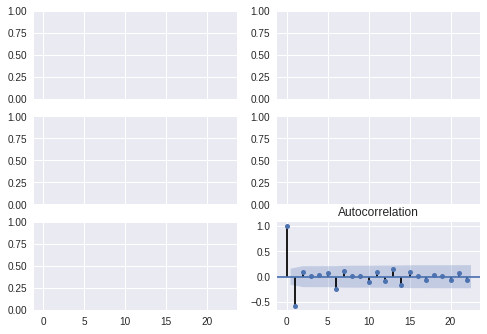

In [110]:
# Graph #3
# Original Series
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
# axes[0, 0].plot(df_ts); axes[0, 0].set_title('Original Series')
# plot_acf(df_ts, ax=axes[0, 1])
# plt.close()

# # 1st Differencing
#axes[1, 0].plot(df_ts.diff()); axes[1, 0].set_title('1st Order Differencing')
#plot_acf(df_ts.diff().dropna(), ax=axes[1, 1])

# # 2nd Differencing
#axes[2, 0].plot(df_ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_ts.diff().diff().dropna(), ax=axes[2, 1]) # orig_diff

plt.show()

- For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

- So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

#### Observations: ACF and PACF Analysis
- TBD

## AR/MA Modeling

 __NOTE:__
Detrend your time series using differencing. AR/MA models represent stationary processes, so we have to make sure there are no trends in our time series. 

Before you can use AR/MA for modeling the timeseries data __must__ be stationary.   If not, the dataset will need to be transformed using serveral strategies, such as: __1_ Detrending, 2_ Differencing, 3_ Log, Cube, etc. 4_ combinations__ (eg. Log with differencing or Subtracting the rolling mean with differencing 1-4) of these strategies.

## ARIMA Modeling
> Autoregressive Integrated Moving Average (or ARIMA), is one of the most widely used forecasting methods for univariate time series data forecasting.  Corrects for non-stationarity by differencing by specified number of terms (d), includes lagged dependent variables (p) and lagged residuals (q) for specified number of periods.

__Autoregressive Integrated Moving Average (or ARIMA)__, is one of the most widely used forecasting methods for univariate time series data forecasting.  Although __the method can handle data with a trend__, it __does not support time series with a seasonal component__.  ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA/X.

- __Autoregression Intuition__ Consider a time series that was generated by an autoregression (AR) process with a lag of k.  We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.  This means we would expect the ACF for the AR(4) time series to be strong to a lag of 4wks and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.  We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond (2).
- __Moving Average Intuition__ Consider a time series that was generated by a moving average (MA) process with a lag of k.  Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.  We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.  For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.


In [111]:
# Dynamically change the default rc settings
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':60})

- To customize the properties and default styles of Matplotlib update parameters to dynamically change the default rc settings in a python script or interactively from the python shell. All of the rc settings are stored in a dictionary-like variable called matplotlib.rcParams, which is global to the matplotlib package.

### Model 1 | ARIMA

                              ARMA Model Results                              
Dep. Variable:            is_canceled   No. Observations:                  153
Model:                     ARMA(2, 4)   Log Likelihood                -816.563
Method:                       css-mle   S.D. of innovations             49.967
Date:                Fri, 30 Oct 2020   AIC                           1649.125
Time:                        04:51:16   BIC                           1673.369
Sample:                    10-19-2014   HQIC                          1658.973
                         - 09-17-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                55.0883     12.618      4.366      0.000      30.357      79.819
ar.L1.is_canceled     0.8676      0.195      4.441      0.000       0.485       1.250
ar.L2.is_canceled    -0.

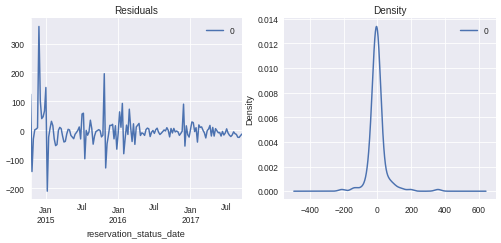

In [112]:
# 2,0,4 ARIMA Model
model = ARIMA(df_ts, order=(2,0,4))  # p,d,q based on ACF/PACF analysis above
model_1_fit = model.fit(disp=0)
print(model_1_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Model 2 | ARIMA

                              ARMA Model Results                              
Dep. Variable:            is_canceled   No. Observations:                  153
Model:                     ARMA(3, 4)   Log Likelihood                -815.521
Method:                       css-mle   S.D. of innovations             49.339
Date:                Fri, 30 Oct 2020   AIC                           1649.042
Time:                        04:51:18   BIC                           1676.316
Sample:                    10-19-2014   HQIC                          1660.122
                         - 09-17-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                54.9872     11.444      4.805      0.000      32.558      77.416
ar.L1.is_canceled     0.2851      0.146      1.949      0.051      -0.002       0.572
ar.L2.is_canceled     0.

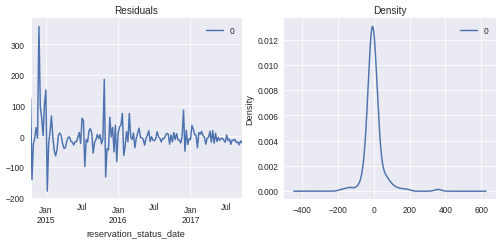

In [113]:
# 3,0,4 ARIMA Model
model = ARIMA(df_ts, order=(3,0,4)) # p,d,q based on ACF/PACF analysis above
model_2_fit = model.fit(disp=0)
print(model_2_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Model 3| ARIMA

                              ARMA Model Results                              
Dep. Variable:            is_canceled   No. Observations:                  153
Model:                     ARMA(1, 4)   Log Likelihood                -820.030
Method:                       css-mle   S.D. of innovations             51.180
Date:                Fri, 30 Oct 2020   AIC                           1654.061
Time:                        04:51:19   BIC                           1675.274
Sample:                    10-19-2014   HQIC                          1662.678
                         - 09-17-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                55.8631     15.899      3.514      0.000      24.701      87.025
ar.L1.is_canceled     0.4402      0.114      3.866      0.000       0.217       0.663
ma.L1.is_canceled     0.

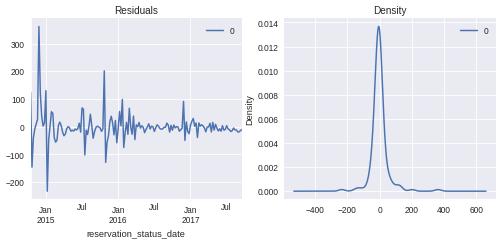

In [114]:
# 1,0,4 ARIMA Model
model = ARIMA(df_ts, order=(1,0,4))  # p,d,q  based on Model1.table[1] analysis
model_3_fit = model.fit(disp=0)
print(model_3_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_3_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The model(1) summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice, the coefficient of the ar.L2.is_canceled (-0.4451) term is close to zero and the P-Value in ‘P>|z|’ column is 0.001. So, we rebuild the model without the ar.L2.is_canceled term = ARMA(1, 4).

#### Observations: ARIMA Modeling
- Conducted ARIMA Modeling assuming no seasonality in the data and did not include differencing because the series was already stationary and trend line was horizontal.
- The model with the best __AIC=1649.125 and BIC=1673.369__ is __Model 1__ .

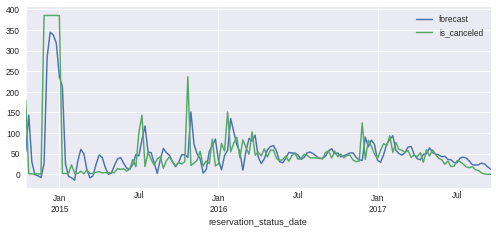

In [115]:
# Actual vs Fitted
model_1_fit.plot_predict(dynamic=False)
plt.show()

- Forecasted line does not fit the actual data as closely as I was hoping for.  We will continue modeling to find a better AIC.

### Differenced Dataset Analysis

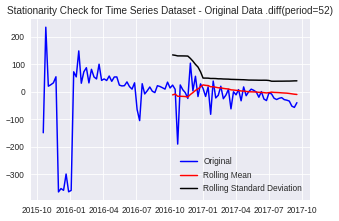

Results of Dickey-Fuller Test
Test Statistic                 -3.682288
p-value                         0.004369
#Lags Used                      1.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [116]:
# Differencing dataset
orig_data_diff = df_ts.diff(periods=52)
orig_data_diff.dropna(inplace=True)
test_stationarity(orig_data_diff,'Time Series Dataset', '- Original Data .diff(period=52)')

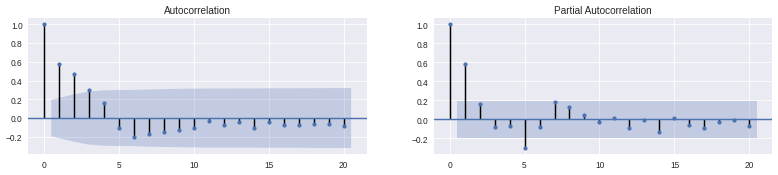

In [117]:
#  Plot ACF and PACF  - Differencing dataset
fig, axes = plt.subplots(ncols=2, nrows=1,figsize =(16,3))
plot_acf(orig_data_diff,  ax= axes[0], lags=20)
plot_pacf(orig_data_diff, ax= axes[1], lags=20, method='ols')

plt.subplots_adjust(hspace = 0.4 )
plt.show()

- PACF = 2 lag (0.6 and -0.3)  
- ACF = 2 or 3 lags (0.6 and 0.5 and maybe 0.3)

### Model 4 | Differenced Dataset

                              ARMA Model Results                              
Dep. Variable:            is_canceled   No. Observations:                  101
Model:                     ARMA(2, 2)   Log Likelihood                -584.732
Method:                       css-mle   S.D. of innovations             78.874
Date:                Fri, 30 Oct 2020   AIC                           1181.464
Time:                        04:51:26   BIC                           1197.154
Sample:                    10-18-2015   HQIC                          1187.816
                         - 09-17-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -13.3613     21.670     -0.617      0.538     -55.833      29.110
ar.L1.is_canceled    -0.0323      0.282     -0.114      0.909      -0.586       0.521
ar.L2.is_canceled     0.

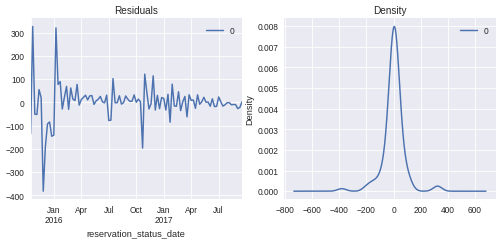

In [118]:
# 2,0,1 ARIMA Model
model = ARIMA(orig_data_diff, order=(2,0,2))  # p,d,q  based Diff ACF/PACF analysis
model_4_fit = model.fit(disp=0)
print(model_4_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_4_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Model 5 | Differenced Dataset 

                              ARMA Model Results                              
Dep. Variable:            is_canceled   No. Observations:                  101
Model:                     ARMA(2, 3)   Log Likelihood                -576.791
Method:                       css-mle   S.D. of innovations             72.340
Date:                Fri, 30 Oct 2020   AIC                           1167.583
Time:                        04:51:26   BIC                           1185.889
Sample:                    10-18-2015   HQIC                          1174.994
                         - 09-17-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -13.7288     18.463     -0.744      0.457     -49.915      22.458
ar.L1.is_canceled     1.0889      0.182      5.973      0.000       0.732       1.446
ar.L2.is_canceled    -0.

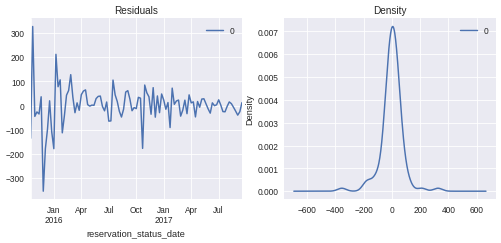

In [119]:
# 1,0,1 ARIMA Model
model = ARIMA(orig_data_diff, order=(2,0,3))  # p,d,q  based model_4.table[1] analysis
model_5_fit = model.fit(disp=0)
print(model_5_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_5_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

#### Observation: Differenced Dataset Analysis
- Differencing the data via transformation (.diff) for period=52 to remove seasonality, improved the model evaluation metrics significantly - __Model 5 = AIC: 1167 and BIC: 1185__ 
- Plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).
- The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

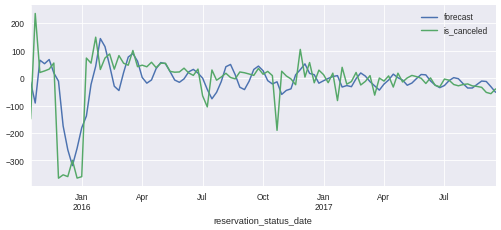

In [120]:
# Actual vs Fitted
model_5_fit.plot_predict(dynamic=False)
plt.show()

- Forecasted line does not fit the actual data as closely as I was hoping for.  We will continue modeling to find a better AIC.

### TBD - EVALUATE DIFF DATA FOR SEASONALITY

- TBD

> Now that we’ve analyzed the data, we can clearly see we have a time series with a seasonal component, so it make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

#### NOTES -  IMPORTANT | MODELING NOTES:  
> The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

> Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.  So, let’s rebuild the model without the MA2 term.

- The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

- Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).
- auto_arima: # frequency of series - The m parameter is the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:7 - daily, 12 - monthly, 52 - weekly.

In [121]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = df_ts
print(df_ts.tail())
# fit model
model = ARIMA(data, order=(2,0,4))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))#, typ='levels')
print(yhat)

                         is_canceled
reservation_status_date             
2017-08-20                  9.285714
2017-08-27                  3.428571
2017-09-03                  0.714286
2017-09-10                  0.000000
2017-09-17                  0.000000
2017-09-24    11.878604
Freq: W-SUN, dtype: float64


#### NOTES - SARIMAX:
> Corrects for seasonality (s) within the data. Given that the data has exhibited seasonality, we would expect the SARIMA/X model to offer the best performance.

- Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

- It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

- ACF and PACF plots can be analyzed to specify values for the seasonal model by looking at correlation at seasonal lag time steps.

#### NOTES - Single Prediction | SARIMA 

In [122]:
# SARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# timeseries dataset
data = df_ts
# fit model
model = SARIMAX(data, order=(2, 0, 4), seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()  #disp=False
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

2017-09-24    20.325999
Freq: W-SUN, dtype: float64


#### NOTES - Interpetation  | ACF/PACF
> __Observation:__ From the plots above, we see that there are autocorrelations for 10 lags and 1 lags for partial correlation, one very strong correlation the previous month. So we will build ARIMA models with varied combinations of orders in (p (for AR), d (for differencing), q (for MA)) from 0 to 1 order for both seasonal and non-seasonal part.

> We interpret this as, historic house prices for about 10 periods (months) seem to be important in determinging the value of houses today. However, once the prior periods are controlled for, by the partial autocorrelation plot, this falls to 2 lagged periods. We would therefore expect 2 lagged dependent variables and/or 2 lagged residuals to be necessary in our model.

## ARIMA auto-parameter selection

In [124]:
#!pip install pyramid-arima
!pip install pmdarima

# Installing collected packages: pyramid-arima
# Successfully installed pyramid-arima-0.9.0

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 18.8 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


> This library contains an auto_arima function that allows us to set a range of p,d,q,P,D,and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC value.

### Model 6 | auto_arima

In [125]:
# Conduct modeling using auto_arima -- No Seasonality  (Dataset: df_ts)
from pmdarima import auto_arima

model = auto_arima(df_ts, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1668.316, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1819.598, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1668.114, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1737.485, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1668.073, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1669.882, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1669.981, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1671.564, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1662.006, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1660.583, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1758.961, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1662.138, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1697.909, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1663.708, Time=0.24 sec

Best model:  ARIMA(1,0,0)(0,0,0)

### Model 7 | auto_arima

In [126]:
# Conduct modeling using auto_arima -- No Seasonality (Dataset: Differenced)
from pmdarima import auto_arima
model = auto_arima(orig_data_diff, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1177.749, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1219.284, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1178.135, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1194.875, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1177.882, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1177.521, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1183.398, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1172.622, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1183.130, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1166.131, Time=0.19 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1167.583, Time=0.29 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
T

### Model 8 | auto_arima

In [ ]:
# Conduct modeling using auto_arima -- With Seasonality (Dataset: df_ts)
from pmdarima import auto_arima
model = auto_arima(df_ts, start_p=1, start_q=1,
                           max_p=6, max_q=6, 
                           m=52,
                           start_P=0, 
                           seasonal=True,    # Include Seasonality
                           d=1, D=1,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=11.43 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1186.711, Time=0.55 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1163.901, Time=3.09 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=11.28 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1176.072, Time=0.59 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=41.09 sec


### Model 9 | auto_arima

In [ ]:
# Conduct modeling using auto_arima -- With Seasonality (Dataset: df_ts)
from pmdarima import auto_arima
model = auto_arima(df_ts, start_p=1, start_q=1,
                           max_p=6, max_q=6, 
                           m=52,
                           start_P=0, 
                           seasonal=True,    # Include Seasonality
                           test='adf',       # use adftest to find optimal 'd'
                           d=None, D=None, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())  

#### Observation: auto_arima
> We now have a model that we can fit, in order to do this , we will need training data and test data.

> The output of our code suggests that __SARIMAX(1, 1, 1)x(1, 1, 1, 12)__ yields the lowest AIC value of __277.78__. We should therefore consider this to be optimal option out of all the models we have considered.

## SARIMAX Modeling

> Now that we’ve analyzed the data, we can clearly see we have a time series with a seasonal component, so it make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

### Model 10 |SARIMAX(2,1,3)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2, 1, 3),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

### Model 11 |SARIMAX(2,1,2)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

### Model 12  |SARIMAX(1,3,3)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(1, 3, 3),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

### Model 13  |SARIMAX(2,2,3)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2, 2, 3),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

### Model 14 | SARIMAX(2, 2, 1)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2, 2, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

### Model 15 | SARIMAX(2, 0, 1)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2, 0, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

### Model 16 | SARIMAX(2, 1, 1)x(1, 1, 0, 52)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(8,8)) 
plt.show()

#### Observation: SARIMAX
> The output of our code suggests that __Model 14: SARIMAX(2,2,1)x(1, 1, 0, 52)__ yields the lowest AIC value of __422.779__. We should therefore consider this to be optimal option out of all the models we have considered.
- SARIMAX(2,2,1)x(1, 1, 0, 52) p-values (P>|z|) 0.000 < .05

# Train Test Split Dataset

> We can then fit the model object to a training data set. Because this is a time series forecast, we will “chop off” a portion of our latest data and use that as the test set. Then we will train on the rest of the data and forecast into the future. Afterwards we can compare our forecast with the section of data we chopped off.

In [ ]:
# Test data contains last year of series
train = df_ts.loc['2014-10-19':'2016-07-31']
test = df_ts.loc['2016-07-31':]   
print(train.head())
print(test.head())
print(train.shape,test.shape)

# Re-Build Model(s)

> You can now build the ARIMA model on training dataset, forecast and plot it.

### ARIMA(2,0,4)

In [ ]:
# Build Model -- model = ARIMA(train, order=(2,0,4))  

model = ARIMA(train, order=(2,0,4))
model_fit = model.fit(disp=-1)  
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(60, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(10,4), dpi=80)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='best', fontsize=8)
plt.show()

### ARIMA(2,1,3)

In [ ]:
# Build Model -- model = ARIMA(train, order=(2,1,3))  

model = ARIMA(train, order=(2,1,3))
model_fit = model.fit(disp=-1)  
print(model_fit.summary())

# Forecast
fc, se, conf = model_fit.forecast(60, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(10,4), dpi=80)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='best', fontsize=8)
plt.show()

- From the chart, the ARIMA(2,0,4) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band, however, each of the predicted forecasts is consistently not in line with the actuals. 
- There is definitely scope for improvement, so, I increased the order of differencing to one, by setting d=1 and decrease q up to 3 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

- While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

#### Observations: Re-Build Model
- The ARIMA model AIC values are still high compared to the SARIMAX AIC values, and the forecast line is consistently far away for the actual values.  Therefore, we will consider SARIMAX(2,2,1)x(1, 1, 0, 52) as our best fit model to buid the forecast against.

# Fit Best Model

> The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.  The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.
- The model with the best performance, as given by the lowest AIC, p-values and evaluation of the residuals will be selected.

### SARIMAX(2,2,1)x(1, 1, 0, 52)

In [ ]:
# Plug the optimal parameter values into a SARIMAX model 
sxmodel = sm.tsa.statespace.SARIMAX(df_ts,
                                order=(2,2,1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model and print results
sxmodel_fit = sxmodel.fit()  #disp=False
print(sxmodel_fit.summary())

In [ ]:
# Call plot_diagnostics() on the results calculated above 
sxmodel_fit.plot_diagnostics(figsize=(10, 6))
plt.show()

> __SARIMAX(2,2,1)x(1, 1, 0, 52) p-values (P>|z|) 0.000 < .05__

####  Residual Analysis:
The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model. Let's check for these assumptions from diagnostics plots:

- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals may be quite normally distributed.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) mostly follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). With very little deviation away from the red line would imply the distribution is normally distributed.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.


> These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

# Validating the Model

#### One-step Ahead Forecasting

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

- The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

- For get_predictions(), set the dynamic parameter to False to ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

In [ ]:
# Get predictions starting from '2017-04-02' and calculate confidence intervals
pred = sxmodel_fit.get_prediction(start=pd.to_datetime('2017-04-02'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_ts['2014-10-19':].plot(label='Observed')  

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.2)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('# Cancellations')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
ts_forecasted = pred.predicted_mean
ts_truth = test['2017-04-02':]

# Compute evaluation metrics
print(f'Mean squared error: {mean_squared_error(ts_truth, ts_forecasted)}')
print(f'Mean absolute error: {mean_absolute_error(ts_truth, ts_forecasted)}')
mse = mean_squared_error(ts_truth, ts_forecasted)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

#### Dynamic Forecasting

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = sxmodel_fit.get_prediction(start=pd.to_datetime('2017-04-02'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = df_ts['2014-10-19':].plot(label='observed', figsize=(20, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-04-02'), ts_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('# of Cancellations')

plt.legend()
plt.show()

In [ ]:
# Get the real and predicted values
ts_forecasted = pred_dynamic.predicted_mean
ts_truth = test['2017-04-02':]

# Compute evaluation metrics
print(f'Mean squared error: {mean_squared_error(ts_truth, ts_forecasted)}')
print(f'Mean absolute error: {mean_absolute_error(ts_truth, ts_forecasted)}')
mse = mean_squared_error(ts_truth, ts_forecasted)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

#### Observations: Validation
- RMSE value ≥0.5 reflects the poor ability of the model to accurately predict the data, in this case RMSE: 14.54 from One-step Ahead Forecasting.

# Perform Predictions

In [ ]:
# Get forecast 500 steps ahead in future
prediction = sxmodel_fit.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
#We can use the output of this code to plot the time series and forecasts of its future values.

# Plot future predictions with confidence intervals
ax = df_ts.plot(label='observed', figsize=(20, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('# of Cancellations')

plt.legend()
plt.show()

## Make Single Prediction

In [ ]:
# SARIMAX  - Make Single Prediction
y_pred = sxmodel_fit.predict((len(data)+13), (len(data)+13))  # Prediction for a specific week.
print(y_pred)

# Interpreting Results

- RMSE value ≥0.5 reflects the poor ability of the model to accurately predict the data, in this case RMSE: 14.54 from One-step Ahead Forecasting.

# Recommendations

- This time series has low-volume count data (less than 3 years of data); having MORE data could greatly improve the forecasting.

# Future Work

- Conduct Time Series Forecasting using FB Prophet to evaluate any improvements in prediction metrics.
- If more time and resources were available I would investigate other economical factors, and not relying solely on historical trends in "# of cancellations"; such as, local economies, daily weather temperatures/conditions, events and holidays.
- Perform time series by Hotel type (City Hotel vs Resort); by Country to compare and understand cancellation predictions by top 10 Countries.

In [ ]:
end = datetime.datetime.now()
elapsed_time = end - start
print(f'Time Series Total Execution Time: {elapsed_time}')

# Notes

####  Residual Analysis:
The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model. Let's check for these assumptions from diagnostics plots:

- In the top right plot, we see that the red KDE line does not quite follow closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals may not be quite normally distributed.

- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) mostly follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). However, the deviations away from the red line would imply the distribution is skewed compared to a strong indication that the residuals are normally distributed.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

- These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

# End Study